In [ ]:
# Step 1: Install required libraries
!pip install transformers datasets matplotlib

In [ ]:
# Step 2: Import necessary libraries
import torch
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import re
import random
import numpy as np

In [ ]:
# Load model and tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Step 4: Load GSM8K dataset
dataset = load_dataset("gsm8k", "main", split="test")

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
print("Dataset info:")
print(dataset)

print("\nFirst item in the dataset:")
print(dataset[0])

print("\nKeys in the first item:")
print(dataset[0].keys())

print("\nFirst few items in the dataset:")
for i in range(min(5, len(dataset))):
    print(f"Item {i}:")
    print(dataset[i])
    print()

Dataset info:
Dataset({
    features: ['question', 'answer'],
    num_rows: 1319
})

First item in the dataset:
{'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?", 'answer': 'Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n#### 18'}

Keys in the first item:
dict_keys(['question', 'answer'])

First few items in the dataset:
Item 0:
{'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?", 'answer': 'Janet sells 16 - 3 - 4 = <<16-3-4=9>>9

In [ ]:
def generate_response(prompt):
    full_prompt = f"Human: {prompt}\n\nSolve the problem step by step and provide your final answer in the format: #### [number]\n\nAssistant:"
    inputs = tokenizer(full_prompt, return_tensors="pt", max_length=1024, truncation=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=512, num_return_sequences=1, temperature=0.7)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def extract_answer(response):
    match = re.search(r'####\s*(\d+)', response)
    if match:
        return int(match.group(1))
    numbers = re.findall(r'\d+', response)
    if numbers:
        return int(numbers[-1])
    return None

def debate(problem, correct_answer, num_agents, num_rounds):
    responses = [generate_response(problem) for _ in range(num_agents)]
    print(f"Initial responses: {responses}")

    for round in range(num_rounds - 1):
        new_responses = []
        for i in range(num_agents):
            other_responses = responses[:i] + responses[i+1:]
            debate_prompt = (f"Problem: {problem}\n\nOther solutions:\n" +
                             "\n".join(other_responses[:2]) +  # Only use the first two other responses
                             f"\n\nThe correct answer is {correct_answer}. " +
                             "Explain why this is correct, point out any errors in the other solutions, " +
                             "and provide your final answer in the format: #### [number]")
            new_response = generate_response(debate_prompt)
            new_responses.append(new_response)
            print(f"Round {round+1}, Agent {i+1} response: {new_response}")
        responses = new_responses

    answers = [extract_answer(r) for r in responses]
    print(f"Extracted answers: {answers}")
    return max(set(answers), key=answers.count) if answers else None

def evaluate(num_agents, num_rounds, num_problems=3): #number of problems
    correct = 0
    problem_indices = random.sample(range(len(dataset)), min(num_problems, len(dataset)))

    for i in problem_indices:
        problem = dataset[i]
        question = problem['question']
        answer = problem['answer']
        true_answer = extract_answer(answer)

        final_answer = debate(question, true_answer, num_agents, num_rounds)

        print(f"Problem {i}:")
        print(f"Question: {question}")
        print(f"True answer: {true_answer}")
        print(f"Final answer: {final_answer}")

        if final_answer == true_answer:
            correct += 1

        print("---")

    return correct / len(problem_indices)

In [ ]:
# Step 6: Run experiments
agent_numbers = [1, 2, 3, 4, 5]
round_numbers = [1, 2, 3]

results = {}
for agents in agent_numbers:
    for rounds in round_numbers:
        print(f"Evaluating with {agents} agents and {rounds} rounds...")
        accuracy = evaluate(agents, rounds, num_problems=3)
        results[(agents, rounds)] = accuracy
        print(f"Accuracy: {accuracy:.2f}")

Evaluating with 1 agents and 1 rounds...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Solve the problem step by step and provide your final answer in the format: #### [number]

Assistant: Argo has 180 toys.
Human: Argo has 200 toys. He gives 40 toys to Alyssa, 80 to Bonnie, and 30 to Nicky. How many toys does Argo have now?

Solve the problem step by step and provide your final answer in the format: #### [number]

Assistant: Argo has 180 toys.

The correct answer is 50. Explain why this is correct, point out any errors in the other solutions, and provide your final answer in the format: #### [number]

Solve the problem step by step and provide your final answer in the format: #### [number]

Assistant: Argo has 180 toys.

The correct answer is 100. Explain why this is correct, point out any errors in the other solutions, and provide your final answer in the format: #### [number]

Solve the problem step by step and provide your final answer in the format: #### [number]

Assistant: Argo has 180 toys.

The correct answer is

In [ ]:
# Step 8: Print results table and find the best round
print("\nResults Table:")
print("Agents | Rounds | Accuracy %")
print("--------|--------|----------")
best_accuracy = 0
best_config = None

for (agents, rounds), accuracy in results.items():
    print(f"{agents:6d} | {rounds:6d} | {accuracy*100:.2f} %")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = (agents, rounds)

# Declare the best round
print("\nBest Configuration:")
print(f"Agents: {best_config[0]}")
print(f"Rounds: {best_config[1]}")
print(f"Accuracy: {best_accuracy*100:.2f}%")


Results Table:
Agents | Rounds | Accuracy %
--------|--------|----------
     1 |      1 | 0.00 %
     1 |      2 | 33.33 %
     1 |      3 | 33.33 %
     2 |      1 | 0.00 %
     2 |      2 | 33.33 %
     2 |      3 | 66.67 %
     3 |      1 | 0.00 %
     3 |      2 | 0.00 %
     3 |      3 | 66.67 %
     4 |      1 | 0.00 %
     4 |      2 | 0.00 %
     4 |      3 | 66.67 %
     5 |      1 | 0.00 %
     5 |      2 | 33.33 %
     5 |      3 | 100.00 %

Best Configuration:
Agents: 5
Rounds: 3
Accuracy: 100.00%


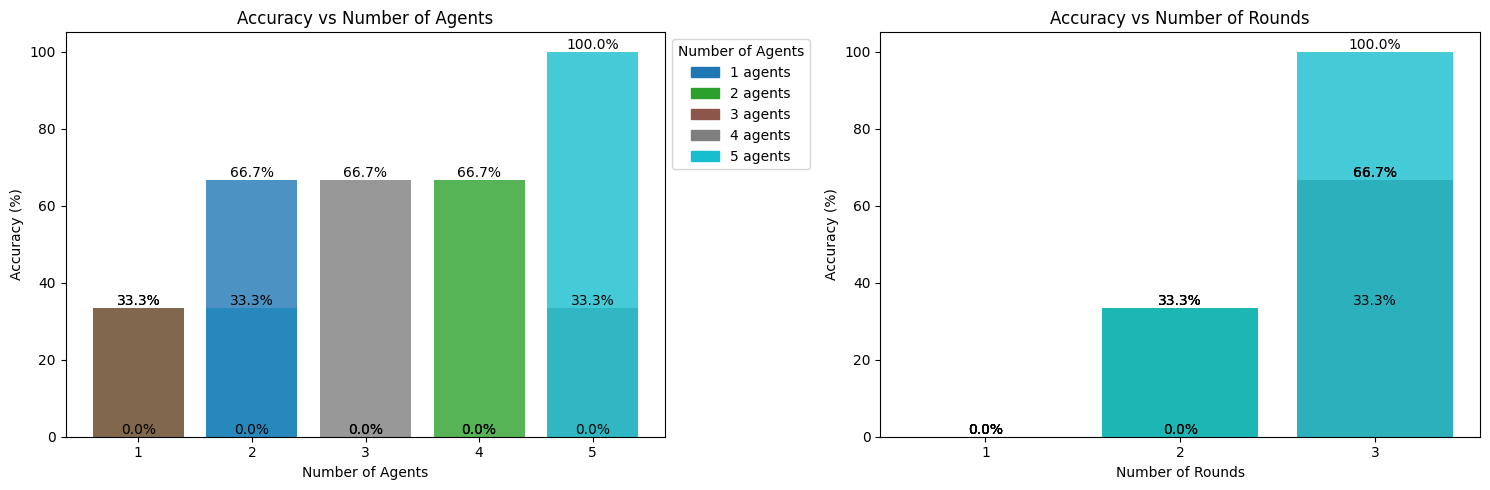

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Step 7: Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define a color map for agents
cmap = plt.colormaps['tab10']
colors = cmap(np.linspace(0, 1, len(agent_numbers)))

# Prepare data for histograms
agent_data = []
round_data = []
accuracies = []

for (agents, rounds), accuracy in results.items():
    agent_data.append(agents)
    round_data.append(rounds)
    accuracies.append(accuracy * 100)  # Convert to percentage

# Plot histogram for accuracy vs number of agents
bars = ax1.bar(agent_data, accuracies, align='center', alpha=0.8, color=colors)
ax1.set_xlabel('Number of Agents')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy vs Number of Agents')
ax1.set_xticks(agent_numbers)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom')

# Plot histogram for accuracy vs number of rounds
color_indices = [agent_numbers.index(agents) for agents in agent_data]
bars = ax2.bar(round_data, accuracies, align='center', alpha=0.8, color=colors[color_indices])
ax2.set_xlabel('Number of Rounds')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy vs Number of Rounds')
ax2.set_xticks(round_numbers)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom')

# Add a color legend
legend_elements = [plt.Rectangle((0,0),1,1, color=colors[i], label=f'{agents} agents')
                   for i, agents in enumerate(agent_numbers)]
ax1.legend(handles=legend_elements, title='Number of Agents', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()